In [1]:
#import torch
#print(torch.__version__)
#print(torch.cuda.is_available())

In [2]:
#Install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
    
from fastkaggle import *  


First, we'll get the data. 

In [3]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [4]:
path

Path('paddy-disease-classification')

In [5]:
#Now we can import the stuff we'll need from fastai
#Install fastai if not available
try: import fastai
except ModuleNotFoundError:
    !pip install fastai
    
from fastai.vision.all import *

#path.ls()

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Looking at the data


The images are in train_images, so let's grab a list of all of them:

In [6]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


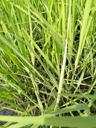

In [7]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like the images might be 480x640 -- let's check all their sizes.

In [8]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

They're nearly all the same size, except for a few. Because of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. For now, we'll just squish them to 480x480 images, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by aug_transforms. We'll start out with small resized images, since we want to be able to iterate quickly:

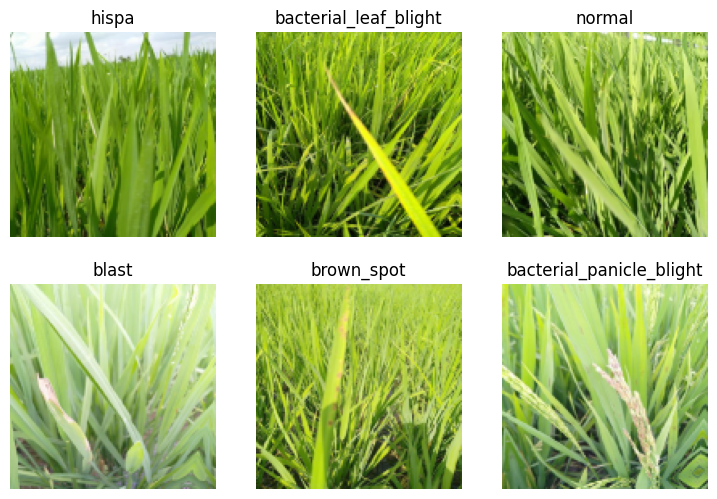

In [9]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

Our first model


Let's create a model. 

In [10]:
#Install timm if not available
try: import timm
except ModuleNotFoundError:
    !pip install timm

In [15]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')

SuggestedLRs(valley=0.0010000000474974513, slide=0.0063095735386013985)

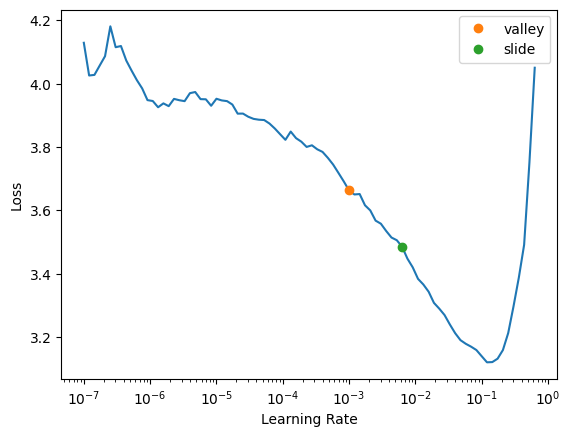

In [16]:
learn.lr_find(suggest_funcs=(valley, slide))

In [17]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.774658,1.319776,0.407496,01:45


epoch,train_loss,valid_loss,error_rate,time
0,1.100642,0.831100,0.256127,01:49
1,0.758336,0.481266,0.156655,01:51
2,0.557066,0.422284,0.131187,01:47


Submitting to Kaggle

In [18]:
ss = pd.read_csv(path/'sample_submission.csv')

In [19]:
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


OK so we need a CSV containing all the test images, in alphabetical order, and the predicted label for each one. We can create the needed test set using fastai like so:

In [20]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by get_preds are the targets, which are blank for a test set, so we discard them):

In [21]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 7,  ..., 8, 1, 5])

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the vocab:

In [22]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [23]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

Kaggle expects the submission as a CSV file, so let's save it, and check the first few lines:

In [24]:
ss['label'] = results
ss.to_csv(path/'subm.csv', index=False)
!head subm.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli(path/'subm.csv', 'Part1-initial rn26d 128px', comp)

100%|██████████| 73.6k/73.6k [00:01<00:00, 44.9kB/s]
